# Quadratic Function

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.optim

In [2]:
x_0 = 2.0
y_0 = 1.0

def f(x, y): # make sure that f can handle tensor arguments of arbitrary size
    delta_0 = x - x_0
    delta_1 = y - y_0
    return delta_0**2 + delta_1**2 + delta_0 * delta_1

def grad_f(x, y): # debug
    with torch.no_grad():
        delta_0 = x - x_0
        delta_1 = y - y_0
        return (2 * delta_0 + delta_1, 2 * delta_1 + delta_0)

In [3]:
f(0, 0)

7.0

In [4]:
f(2, 1)

0.0

In [5]:
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
y = torch.tensor([[-1.0, 0.0], [1.0, 2.0]])
f(x, y)

tensor([[7., 1.],
        [1., 7.]])

In [6]:
x = torch.linspace(0.0, 4.0, 100)
y = torch.linspace(-1.0, 3.0, 100)
X, Y = torch.meshgrid(x, y, indexing="ij")
Z = f(X, Y)

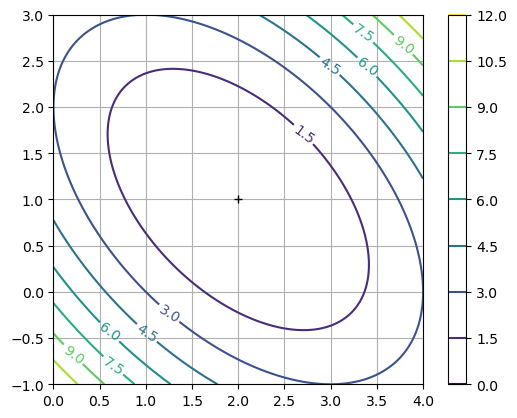

In [7]:
def contour():
    cs = plt.contour(X, Y, Z)
    plt.plot(2.0, 1.0, "k+")
    axes = plt.gca()
    axes.clabel(cs)
    plt.colorbar()
    plt.grid(True)
    axes.set_aspect(1.0)
contour()

In [8]:
x = torch.tensor(1.0)
y = x*x + 1
print(x, y, x.grad)
# y.backward() # won't work: RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn. OK!

tensor(1.) tensor(2.) None


In [9]:
x = torch.tensor(1.0, requires_grad=True)
y = x*x  + 1
print(x, y, x.grad)
y.backward()
print(x, y, x.grad)
x.grad += 1.0
print(x.grad)

tensor(1., requires_grad=True) tensor(2., grad_fn=<AddBackward0>) None
tensor(1., requires_grad=True) tensor(2., grad_fn=<AddBackward0>) tensor(2.)
tensor(3.)


In [10]:
def manual_gradient(x0=0.0, y0=0.0, lr=0.1, n=10):
    x = torch.tensor(x0, requires_grad=True)
    x.grad = torch.tensor(0.0)
    y = torch.tensor(0.0, requires_grad=True)
    y.grad = torch.tensor(y0)
    
    xs, ys, zs = [], [], []
    for i in range(n):
        x.grad = torch.tensor(0.0)
        y.grad = torch.tensor(0.0)
        z = f(x, y)
        z.backward()
        
        xs.append(x.item())
        ys.append(y.item())
        zs.append(z.item())

        x.requires_grad = False
        y.requires_grad = False
        x -= lr * x.grad # RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.
        y -= lr * y.grad # with torch.no_grad() (or equivalent) is required
        x.requires_grad = True
        y.requires_grad = True
    return xs, ys, zs

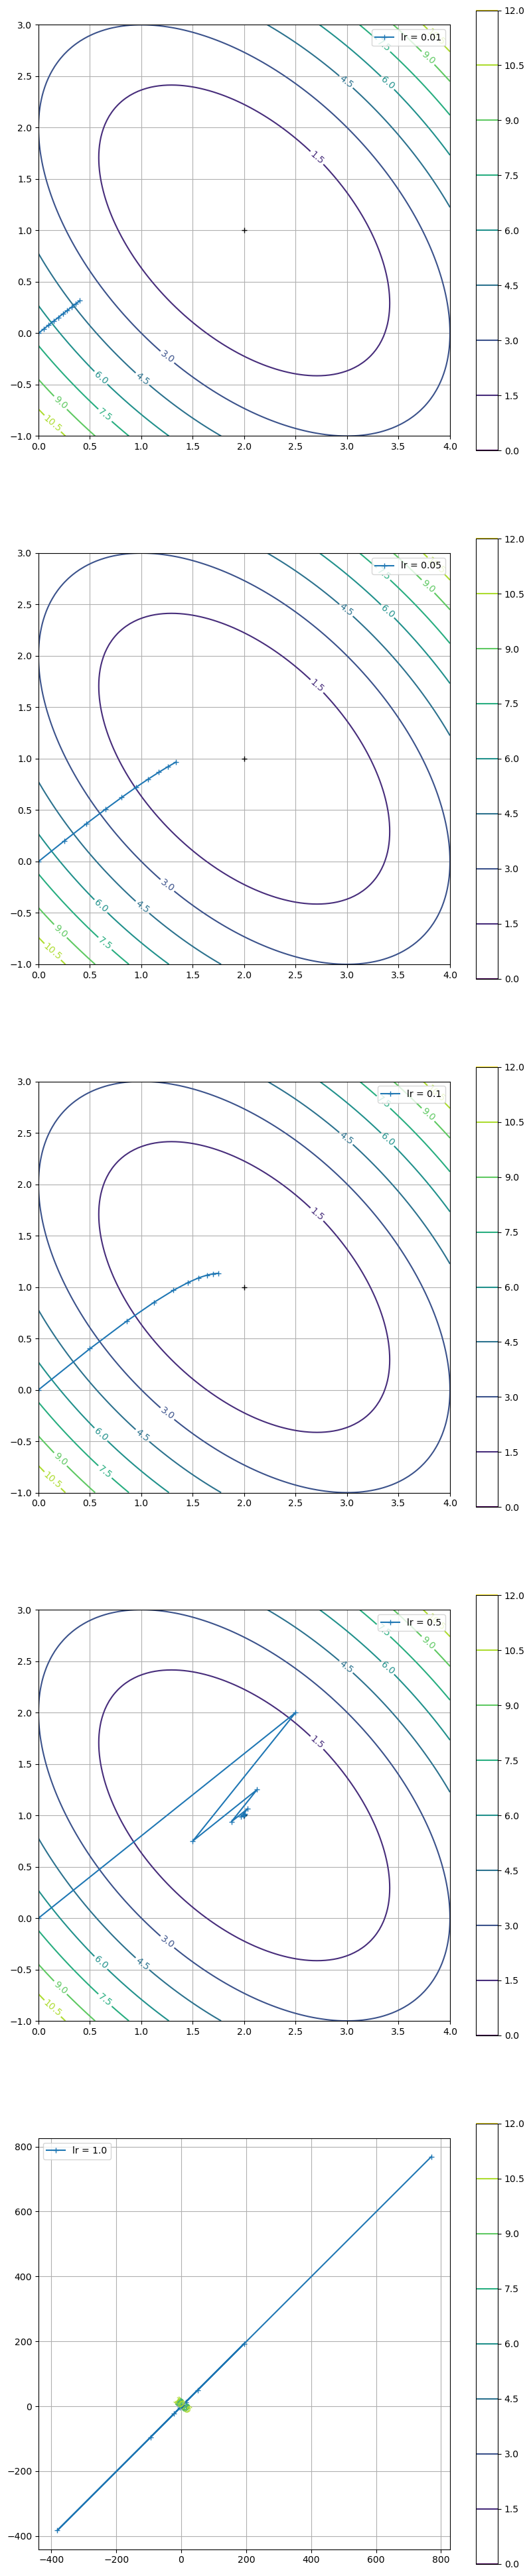

In [16]:
lrs = [0.01, 0.05, 0.1, 0.5, 1.0]
n = 100
fig, axes = plt.subplots(len(lrs))
fig.set_figheight(len(lrs)*10)
fig.set_figwidth(10)
for ax, lr in zip(axes, lrs):
    plt.sca(ax)
    contour()
    xs, ys, _ = manual_gradient(lr=lr, n=10)
    plt.plot(xs, ys, "-+", label="lr = " +str(lr))
    plt.legend()

In [25]:
def min_SGD(x0=0.0, y0=0.0, n=10, **options):
    x = torch.tensor(x0, requires_grad=True)
    x.grad = torch.tensor(0.0)
    y = torch.tensor(0.0, requires_grad=True)
    y.grad = torch.tensor(y0)
    optimizer = torch.optim.SGD([x, y], **options)
    
    xs, ys, zs = [], [], []
    for i in range(n):
        z = f(x, y)
        xs.append(x.item())
        ys.append(y.item())
        zs.append(z.item())
        x.grad.zero_()
        y.grad.zero_()
        z.backward(); optimizer.step()
    return xs, ys, zs

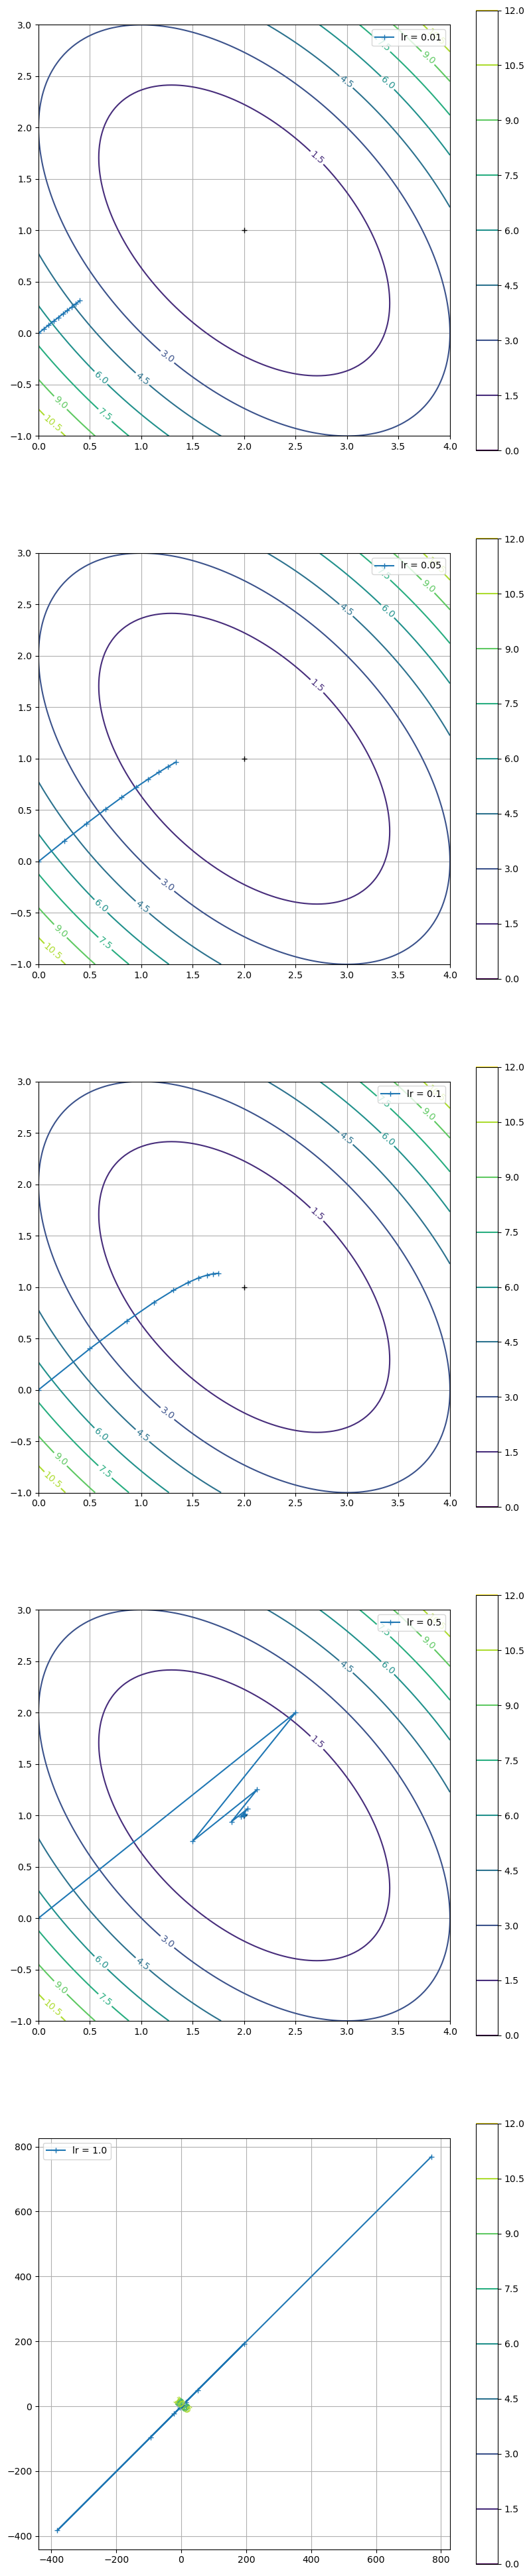

In [26]:
lrs = [0.01, 0.05, 0.1, 0.5, 1.0]
n = 10
fig, axes = plt.subplots(len(lrs))
fig.set_figheight(len(lrs)*10)
fig.set_figwidth(10)
for ax, lr in zip(axes, lrs):
    plt.sca(ax)
    contour()
    xs, ys, _ = min_SGD(n=n, lr=lr)
    plt.plot(xs, ys, "-+", label="lr = " +str(lr))
    plt.legend()

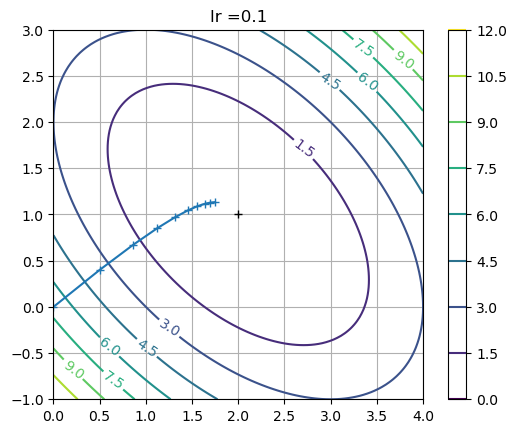

In [48]:
lr = 0.1
n = 10

contour()
xs, ys, _ = min_SGD(n=n, lr=lr)
plt.plot(xs, ys, "-+")
plt.title(f"{lr =}")
None

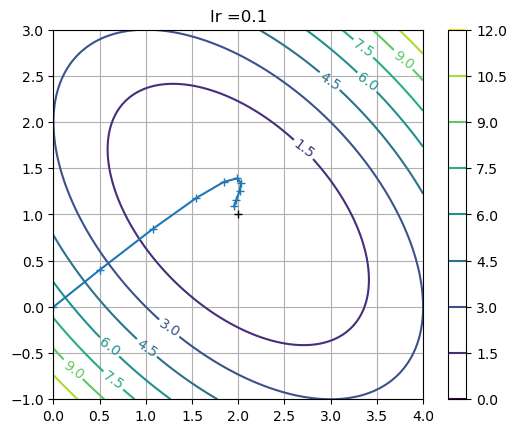

In [62]:
n = 10

contour()
xs, ys, _ = min_SGD(n=n, lr=0.1, momentum=0.5, dampening=0.1)
plt.plot(xs, ys, "-+")
plt.title(f"{lr =}")
None

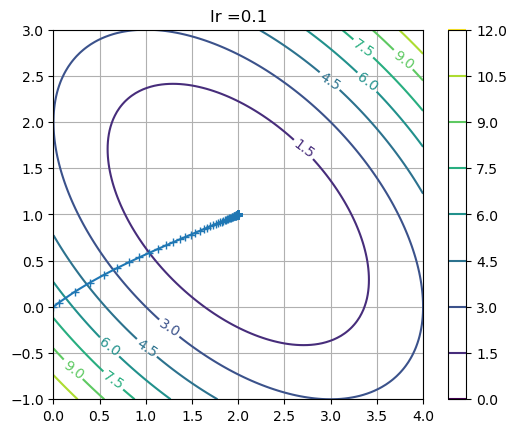

In [71]:
def min_LBFGS(x0=0.0, y0=0.0, n=10, **options):
    x = torch.tensor(x0, requires_grad=True)
    x.grad = torch.tensor(0.0)
    y = torch.tensor(0.0, requires_grad=True)
    y.grad = torch.tensor(y0)
    optimizer = torch.optim.LBFGS([x, y], **options)

    xs, ys, zs = [], [], []
    
    for i in range(n):
        def closure():
            z = f(x, y)
            xs.append(x.item())
            ys.append(y.item())
            zs.append(z.item())
            x.grad.zero_()
            y.grad.zero_()
            z.backward()
            return z
        optimizer.step(closure)
    return xs, ys, zs

n = 10

contour()
xs, ys, _ = min_LBFGS(n=n, lr=0.1)
plt.plot(xs, ys, "-+")
plt.title(f"{lr =}")
None

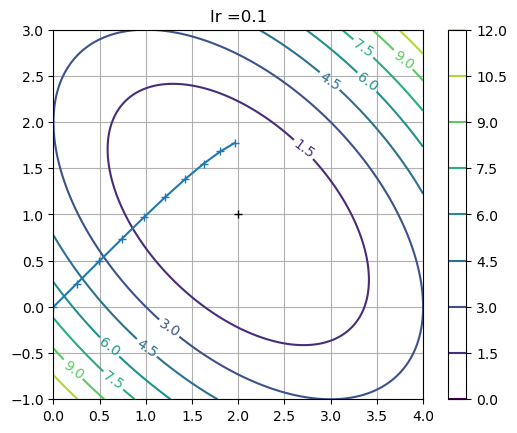

In [81]:
def min_Adam(x0=0.0, y0=0.0, n=10, **options):
    x = torch.tensor(x0, requires_grad=True)
    x.grad = torch.tensor(0.0)
    y = torch.tensor(0.0, requires_grad=True)
    y.grad = torch.tensor(y0)
    optimizer = torch.optim.Adam([x, y], **options)

    xs, ys, zs = [], [], []
    
    for i in range(n):
        def closure():
            z = f(x, y)
            xs.append(x.item())
            ys.append(y.item())
            zs.append(z.item())
            x.grad.zero_()
            y.grad.zero_()
            z.backward()
            return z
        optimizer.step(closure)
    return xs, ys, zs

n = 10

contour()
xs, ys, _ = min_Adam(n=n, lr=0.25)
plt.plot(xs, ys, "-+")
plt.title(f"{lr =}")
None